In [1]:
import os
import torch
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import timm
from torch import nn
from torchvision import transforms
from tqdm import tqdm
import pandas as pd

In [2]:
# Encoder 클래스 정의
class Encoder(nn.Module):
    def __init__(self, args, pretrained=False):
        super().__init__()
        model_name = args.encoder
        self.model_name = model_name
        if model_name.startswith('resnet'):
            self.model_type = 'resnet'
            self.cnn = timm.create_model(model_name, pretrained=pretrained)
            self.n_features = self.cnn.num_features  # encoder_dim
            self.cnn.global_pool = nn.Identity()
            self.cnn.fc = nn.Identity()
        elif model_name.startswith('swin'):
            self.model_type = 'swin'
            self.transformer = timm.create_model(model_name, pretrained=pretrained, pretrained_strict=False,
                                                 use_checkpoint=args.use_checkpoint)
            self.n_features = self.transformer.num_features
            self.transformer.head = nn.Identity()
        elif 'efficientnet' in model_name:
            self.model_type = 'efficientnet'
            self.cnn = timm.create_model(model_name, pretrained=pretrained)
            self.n_features = self.cnn.num_features
            self.cnn.global_pool = nn.Identity()
            self.cnn.classifier = nn.Identity()
        else:
            raise NotImplemented

    def swin_forward(self, transformer, x):
        x = transformer.patch_embed(x)
        if transformer.absolute_pos_embed is not None:
            x = x + transformer.absolute_pos_embed
        x = transformer.pos_drop(x)

        def layer_forward(layer, x, hiddens):
            for blk in layer.blocks:
                if not torch.jit.is_scripting() and layer.use_checkpoint:
                    x = torch.utils.checkpoint.checkpoint(blk, x)
                else:
                    x = blk(x)
            H, W = layer.input_resolution
            B, L, C = x.shape
            hiddens.append(x.view(B, H, W, C))
            if layer.downsample is not None:
                x = layer.downsample(x)
            return x, hiddens

        hiddens = []
        for layer in transformer.layers:
            x, hiddens = layer_forward(layer, x, hiddens)
        x = transformer.norm(x)  # B L C
        hiddens[-1] = x.view_as(hiddens[-1])
        return x, hiddens

    def forward(self, x):
        if self.model_type in ['resnet', 'efficientnet']:
            features = self.cnn(x)
            features = features.permute(0, 2, 3, 1)
        elif self.model_type == 'swin':
            if 'patch' in self.model_name:
                features, _ = self.swin_forward(self.transformer, x)  # Adjust here if more outputs
            else:
                features, _ = self.transformer(x)  # Adjust here if more outputs
        else:
            raise NotImplemented
        return features  # Return only features

In [3]:
# 인코더 모델을 초기화하기 위한 args 설정
class Args:
    def __init__(self):
        self.encoder = 'swin_base_patch4_window7_224'  # 사용할 인코더 모델 이름
        self.use_checkpoint = False  # 스윈 트랜스포머에서 체크포인트 사용 여부

In [4]:
# 모델 로드
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(args, pretrained=False).to(device)

# 훈련된 모델 파라미터 로드
model_path = 'ckpt/swin_base_char_aux_1m680k.pth'  # 실제 모델 파일 경로로 바꾸세요
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['encoder'] if 'encoder' in checkpoint else checkpoint
encoder.load_state_dict(state_dict, strict=False)
encoder.eval()

/home/rlawlsgurjh/miniconda3/envs/molscribe/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716579264291/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Encoder(
  (transformer): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (0): BasicLayer(
        dim=128, input_resolution=(56, 56), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
         

In [5]:
# 데이터 준비 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
def smiles_to_image(smiles, img_size=(224, 224)):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=img_size)
    return img

In [7]:
df = pd.read_csv('train_data/train_data.csv')

smi = df['Smiles'].tolist()

print(smi)

['C[C@@H]1CNC[C@@H](C(=O)Nc2ncc(SCc3ncc(C(C)(C)C)o3)s2)C1', 'CC(C)(O)c1cc2nn(C[C@@H]3CCC(=O)N3)cc2cc1NC(=O)c1cccc(C(F)(F)F)n1', 'Nc1n[nH]c2cncc(-c3ccc(NC(=O)Nc4cc(C(F)(F)F)ccc4F)cc3)c12', 'CCCS(=O)(=O)Nc1ccc(F)c(C(=O)Nc2cnc3[nH]c(C)nc3c2)c1F', 'O=S(=O)(Nc1ccc(F)c(Nc2ncccc2-c2ncnc3[nH]cnc23)c1F)N1CC[C@H](O)C1', 'C[C@]1(F)CCC[C@H]1Nc1c(C(N)=O)cnn2cccc12', 'N=C(N)NCCNc1ccc(C(=O)Nc2ccc(N(Cc3ccccc3)Cc3ccccc3)cc2)cc1-c1ccc2ccccc2c1', 'C=CCCCCCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc2OC)C1', 'c1ccc(-c2ccc(Nc3nnc(Cc4ccncc4)c4ccccc34)cc2)cc1', 'N#CCC(=O)N1CC2(CCC(c3cccc4nc(NC(=O)C5CC5)nn34)CC2)C1', 'CC1Cc2c(F)cccc2N1C(=O)Cc1nc(N2CCOCC2)cc(=O)n1C', 'NC(=O)Nc1ccn2c(-c3ccccc3)c(-c3ccc(C4(N)CCC4)cc3)nc2c1', 'C/C(=C\\c1ccccc1)c1ccnc2[nH]c3ccc(-c4ccc(N5CCN(C)CC5)cc4)cc3c12', 'c1cc(-c2ccc3nc(Nc4ccc(OCCN5CCCC5)cc4)ncc3c2)ccn1', 'COc1n[nH]c2ncc(NC(=O)c3cc(NC(=O)c4cccc(C(C)(C)C#N)c4)ccc3F)cc12', 'N#Cc1ccc(NC(=O)N2CCCc3cc(CC(=O)O)c(C=O)nc32)nc1', 'COc1cc(-c2ccc3ncnc(Nc4ccc(C(=O)O)cc4O)c3c2)ccc1O', 'CC(C

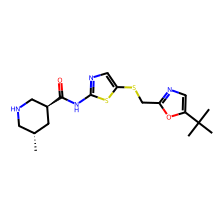

In [8]:
smiles_to_image(smi[0])

In [9]:
feature_vectors = []
for smiles in tqdm(smi):
    img = smiles_to_image(smiles)
    img_tensor = transform(img).unsqueeze(0).to(device)
    features = encoder(img_tensor).detach().cpu().numpy()
    feature_vectors.append(features)

# Print feature vector dimensions
for idx, fv in enumerate(feature_vectors):
    print(f"Feature vector {idx} dimensions: {fv.shape}")

100%|██████████| 5765/5765 [00:59<00:00, 97.49it/s]

Feature vector 0 dimensions: (1, 49, 1024)
Feature vector 1 dimensions: (1, 49, 1024)
Feature vector 2 dimensions: (1, 49, 1024)
Feature vector 3 dimensions: (1, 49, 1024)
Feature vector 4 dimensions: (1, 49, 1024)
Feature vector 5 dimensions: (1, 49, 1024)
Feature vector 6 dimensions: (1, 49, 1024)
Feature vector 7 dimensions: (1, 49, 1024)
Feature vector 8 dimensions: (1, 49, 1024)
Feature vector 9 dimensions: (1, 49, 1024)
Feature vector 10 dimensions: (1, 49, 1024)
Feature vector 11 dimensions: (1, 49, 1024)
Feature vector 12 dimensions: (1, 49, 1024)
Feature vector 13 dimensions: (1, 49, 1024)
Feature vector 14 dimensions: (1, 49, 1024)
Feature vector 15 dimensions: (1, 49, 1024)
Feature vector 16 dimensions: (1, 49, 1024)
Feature vector 17 dimensions: (1, 49, 1024)
Feature vector 18 dimensions: (1, 49, 1024)
Feature vector 19 dimensions: (1, 49, 1024)
Feature vector 20 dimensions: (1, 49, 1024)
Feature vector 21 dimensions: (1, 49, 1024)
Feature vector 22 dimensions: (1, 49, 1024

In [11]:
print(feature_vectors)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

